In [1]:
import pandas as pd
import numpy as np
import random as r
import matplotlib.pyplot as plt
from scipy import stats
from iminuit import Minuit                            
from numpy.linalg import inv
import sys

# NOTES

Check decding decimals  
Double check derivatives in part 2.1  
Double check limits in part 2.1  
Double check 2.3  
DEFINE A GENERAL CHI2 FIT

# Hand in

# General functions:

In [1]:
def get_weighted_mean(x, x_err):
    mean_weighted = np.nansum(x/x_err**2) / np.nansum(1/x_err**2)
    err_weighted = np.sqrt(1/np.sum(1 / x_err**2)) 
    chi2 = np.nansum((x - mean_weighted)**2/x_err**2)
    p = stats.chi2.sf(chi2, len(x) - 1)
    return mean_weighted, err_weighted, chi2, p

def calc_separation(x, y, ddof = 0):
    mean_x = np.mean(x, ddof = ddof)
    mean_y = np.mean(y, ddof = ddof)
    std_x = np.std(x, ddof = ddof)
    std_y = np.std(y, ddof = ddof)
    d = np.abs((mean_x - mean_y)) / np.sqrt(std_x**2 + std_y**2)
    return d

def gauss_pdf(x, mu, sigma) :
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

def calc_ROC(hist1, hist2) :
    # First we extract the entries (y values) and the edges of the histograms:
    y_sig, x_sig_edges, _ = hist1
    y_bkg, x_bkg_edges, _ = hist2
    
    # Check that the two histograms have the same x edges:
    if np.array_equal(x_sig_edges, x_bkg_edges) :
        
        # Extract the center positions (x values) of the bins (both signal or background works - equal binning)
        x_centers = 0.5*(x_sig_edges[1:] + x_sig_edges[:-1])
        
        # Calculate the integral (sum) of the signal and background:
        integral_sig = y_sig.sum()
        integral_bkg = y_bkg.sum()
    
        # Initialize empty arrays for the True Positive Rate (TPR) and the False Positive Rate (FPR):
        TPR = np.zeros_like(y_sig) # True positive rate (sensitivity)
        FPR = np.zeros_like(y_sig) # False positive rate ()
        
        # Loop over all bins (x_centers) of the histograms and calculate TN, FP, FN, TP, FPR, and TPR for each bin:
        for i, x in enumerate(x_centers):     
            # The cut mask
            cut = (x_centers < x)
            # True positive
            TP = np.sum(y_sig[~cut]) / integral_sig    # True positives
            FN = np.sum(y_sig[cut]) / integral_sig     # False negatives
            TPR[i] = TP / (TP + FN)                    # True positive rate
            # True negative
            TN = np.sum(y_bkg[cut]) / integral_bkg      # True negatives (background)
            FP = np.sum(y_bkg[~cut]) / integral_bkg     # False positives
            FPR[i] = FP / (FP + TN)                     # False positive rate            
            
        return FPR, TPR
    
    else:
        AssertionError("Signal and Background histograms have different bins and/or ranges")

In [2]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax 

# 1 - Distributions

## 1.1

In [4]:
mu    = 50
sigma = 20

In [5]:
p_65 = stats.norm.cdf(65, loc = 50, scale = 20) # probability of getting a value from -infinity to 65
p_55 = stats.norm.cdf(55, loc = 50, scale = 20) # probability of getting a value from -infinity to 55
p_interval = p_65 - p_55                  # probability of getting a value between 55 and 65

print(f'Fraction of students in A that get a score between 55 and 65: {p_interval:.3f}')

Fraction of students in A that get a score between 55 and 65: 0.175


In [6]:
print(f'Uncertainty on the mean with 120 scores: \u00B1{sigma / np.sqrt(120):.3f}')

Uncertainty on the mean with 120 scores: ±1.826


If rho_AB is 0, then the measurements are completly indepedent, and probability is thus the product of the indepdents probabilties of getting a score above 70 in any of the tests

In [7]:
p_above_70 = stats.norm.sf(70, loc = 50, scale = 20)**2
print(f'Fraction of students in that get above 70 in both tests: {p_above_70:.3f} (with rho_AB = 0)')

Fraction of students in that get above 70 in both tests: 0.025 (with rho_AB = 0)


In [8]:
N_exp = 100
N = 100000
n = 10000
rho_AB = 0.75

n_ran = np.random.randint(0, N, n)
successes_arr = np.zeros(shape = N_exp)
mean_arr = np.zeros(shape = (2, N_exp))
std_arr  = np.zeros(shape = (2, N_exp))
corr_arr = np.zeros(shape = N_exp)
cov = np.array([[sigma**2, rho_AB*sigma**2],
                [rho_AB*sigma**2, sigma**2]])


for exp in range(N_exp):

    successes = 0
    A_new, B_new = np.random.multivariate_normal([mu, mu], cov, size=N).T


    for i in n_ran:
        if A_new[i] > 70 and B_new[i] > 70:
            successes += 1

    successes_arr[exp] = successes / n
    mean_arr[0, exp]   = np.mean(A_new)
    mean_arr[1, exp]   = np.mean(B_new)
    std_arr[0, exp]    = np.std(A_new)
    std_arr[1, exp]    = np.std(B_new)
    corr_arr[exp]      = stats.pearsonr(A_new, B_new)[0]

In [9]:
print(np.mean(successes_arr), np.std(successes_arr) / np.sqrt(100))
print(np.mean(corr_arr), np.std(corr_arr) / np.sqrt(100))
print(np.mean(mean_arr[0]), np.std(mean_arr[0]) / np.sqrt(100))
print(np.mean(mean_arr[1]), np.std(mean_arr[1]) / np.sqrt(100))
print(np.mean(std_arr[0]), np.std(std_arr[0]) / np.sqrt(100))
print(np.mean(std_arr[1]), np.std(std_arr[1]) / np.sqrt(100))


0.090337 0.00029100053264556077
0.7500064049011885 0.0001247404416241911
50.00531695668593 0.006156872972921807
50.01399597419886 0.005425638376855641
19.996846825573407 0.003766550277901163
20.00297970458522 0.004663394188762949


## MISSING ONE QUESTION

## 1.2
The trick here is to realize that since each spin is indepdents, and we are given a chance of winning and a number of attempts, this is just drawing from a binomial distribution. We look at the intergral of the cummaltive function after the value 8 (aka the survival function).

In [296]:
p_win   = 12 / 37
n_plays = 20
n_win   = 7

p = stats.binom.sf(n_win, n_plays, p_win) # aka 1 - cdf
print(f'Chance to win 8 or more times out of 20: {p:.3f}')


Chance to win 8 or more times out of 20: 0.307


# 2

## 2.1

In [313]:
# define x, y, z1, z2
x, x_err = 1.043, 0.014
y, y_err = 0.07, 0.23

z1 = x * y * np.exp(-y)
z2 = (y + 1)**3 / (x - 1)


# derivatives
dz1_dx = y * np.exp(-y)
dz1_dy = x * np.exp(-y) * (1 - y)

dz2_dx = -(y + 1)**3 / (x - 1)**2
dz2_dy = 3 * (y + 1)**2 / (x - 1)

# contributions of x and y to z1 and z2 propogated error
z1_x_err = (dz1_dx * x_err)
z1_y_err = (dz1_dy * y_err)
          
z2_x_err = (dz2_dx * x_err)
z2_y_err = (dz2_dy * y_err)


# CHECK IF THEESE SHOULD BE SQUARED HERE??

In [317]:
print(f'x contributes: \u00B1 {z1_x_err:.3f} to z1')
print(f'y contributes: \u00B1 {z1_y_err:.3f} to z1')

x contributes: ± 0.001 to z1
y contributes: ± 0.208 to z1


#### So y contributes the most by far

In [318]:
rho_xy = 0.4

z1_err = np.sqrt(z1_x_err**2 + z1_y_err**2 + 2 * rho_xy * dz1_dx * dz1_dy * x_err * y_err)
z2_err = np.sqrt(z2_x_err**2 + z2_y_err**2 + 2 * rho_xy * dz2_dx * dz2_dy * x_err * y_err)

print(f'z1 = {z1:.3f} \u00B1 {z1_err:.3f}')
print(f'z2 = {z2:.3f} \u00B1 {z2_err:.3f}')

z1 = 0.068 ± 0.208
z2 = 28.489 ± 16.948


In [14]:
def z1_fun(x, y):
    return x * y * np.exp(-y)

def z2_fun(x, y):
    return (y + 1)**3 / (x - 1)


we ca ivert this to get


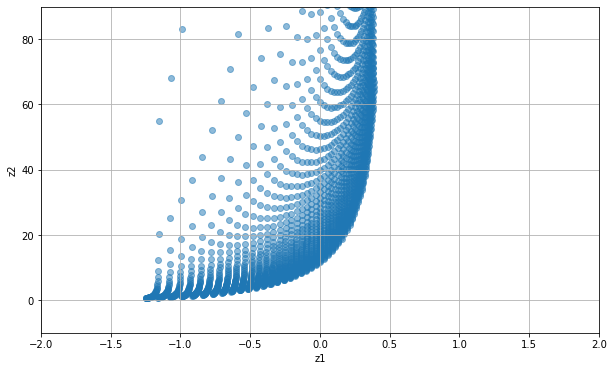

SpearmanrResult(correlation=0.8075687471949997, pvalue=0.0)


In [331]:
x_values = np.linspace(x - 3*x_err, x + 3*x_err, 50)
y_values = np.linspace(y - 3*y_err, y + 3*y_err, 50)

z1_values = z1_fun(np.outer(x_values, np.ones_like(y_values)), np.outer(np.ones_like(x_values), y_values))
z2_values = z2_fun(np.outer(x_values, np.ones_like(y_values)), np.outer(np.ones_like(x_values), y_values))


# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(z1_values.flatten(), z2_values.flatten(), alpha=0.5)
plt.xlim(-2, 2)
plt.ylim(-10, 90)
plt.xlabel('z1')
plt.ylabel('z2')
plt.grid(True)
plt.show()
print(stats.spearmanr(z1_values.flatten(), z2_values.flatten()))

In [330]:
print(np.shape(z1_values.flatten()))

(2500,)


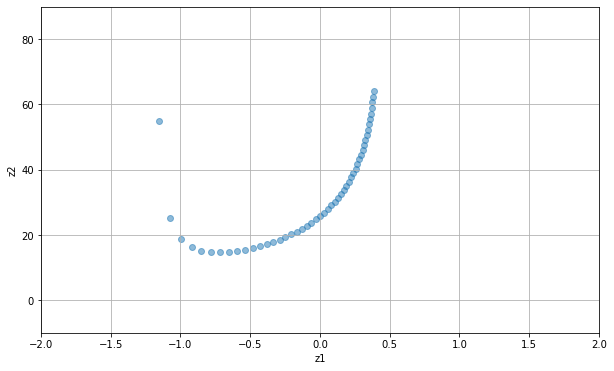

In [16]:
x_values = np.linspace(x - 3*x_err, x + 3*x_err, 50)
y_values = np.linspace(y - 3*y_err, y + 3*y_err, 50)

z1_values = z1_fun(x_values, y_values)
z2_values = z2_fun(x_values, y_values)


# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(z1_values, z2_values, alpha=0.5)
plt.xlim(-2, 2)
plt.ylim(-10, 90)
plt.xlabel('z1')
plt.ylabel('z2')
plt.grid(True)
plt.show()


## 2.2

5.456666666666666
5.435622634270156
0.07415604000950009


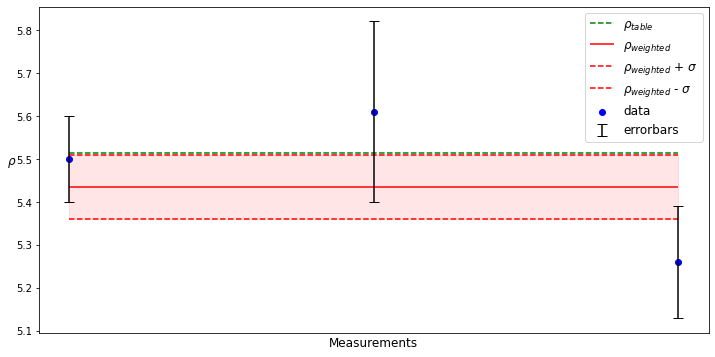

The p value of the weighted avg: 0.572


In [17]:
rho_precise   = 5.514
rho           = np.array([5.50, 5.61, 4.88, 5.07, 5.26])
rho_err       = np.array([0.10, 0.21, 0.15, 0.14, 0.13])

rho           = np.array([5.50, 5.61, 5.26])
rho_err       = np.array([0.10, 0.21, 0.13])



rho_avg       = np.mean(rho)
rho_std       = np.std(rho)
rho_avg_err   = rho_std / len(rho)


wheighted_avg = np.sum(rho / rho_err**2) / np.sum(1 / rho_err**2)
weighted_err  = np.sqrt(1/np.sum(1 / rho_err**2)) 


print(rho_avg)
print(wheighted_avg)
print(weighted_err)

fig, ax = plt.subplots(figsize = (12,6))

#ax.hlines(rho_avg, 0, 4, color = 'red', ls = '--', label = 'rho_avg')
ax.hlines(rho_precise, 0, 2, color = 'green', ls = '--', label = r'$\rho_{table}$')
ax.hlines(wheighted_avg, 0, 2, color = 'red', label = r'$\rho_{weighted}$')
ax.hlines( wheighted_avg + weighted_err, 0, 2, color = 'red', ls = '--', label = r'$\rho_{weighted}$ + $\sigma$')
ax.hlines( wheighted_avg - weighted_err, 0, 2, color = 'red', ls = '--', label = r'$\rho_{weighted}$ - $\sigma$')

ax.fill_between(np.arange(len(rho)), wheighted_avg + weighted_err, wheighted_avg - weighted_err, color = 'red', alpha = 0.1)


ax.errorbar(np.arange(len(rho)), rho, yerr = rho_err, marker='', linestyle='', capsize=5, ecolor='black', label = 'errorbars')
plt.scatter(np.arange(len(rho)), rho, color = 'blue', label = 'data')
plt.legend(fontsize = 12)
plt.xticks([])
plt.xlabel('Measurements', fontsize = 12)
plt.ylabel(r'$\rho$', fontsize = 12, rotation  = 0)

plt.show()

chi2_val = np.sum((rho_precise - wheighted_avg)**2/rho_err**2)
chi2_prob = stats.chi2.sf(chi2_val, len(rho) - 1)

fig.savefig("2_2new.png")
print(f'The p value of the weighted avg: {chi2_prob:.3f}')



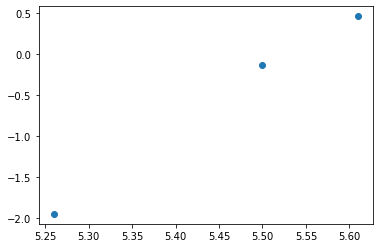

In [18]:
z_scores = (rho - rho_precise) / rho_err
plt.scatter(rho, z_scores)

In [19]:
z = abs(wheighted_avg - rho_precise) / weighted_err
print(z)

1.056924907530168


Can we use chevaneut or peirces criterion maybe?? There is clearly something wrong here.. Results are not accurate

## 2.3

In [332]:
a, a_err = 1.04, 0.27
e, e_err = 0.71, 0.12

A = np.pi * a**2 * np.sqrt(1 - e**2)

dA_da = 2 * np.pi * a * np.sqrt(1- e**2)
dA_de = - np.pi * a**2 * e / np.sqrt(1- e**2)

A_err = np.sqrt((dA_da * a_err)**2 + (dA_de * e_err)**2)

print(f'The area of the elipse is: {A:.3f} \u00B1 {A_err:.3f}')

The area of the elipse is: 2.393 ± 1.309


First lets again estimate the error on lower and upper bound of C

In [21]:
C_low = 4 * a * np.sqrt(2 - e**2)
C_up = np.pi * a * np.sqrt(4 - 2*e**2)

d_C_low_da = 4 * np.sqrt(2 - e**2)
d_C_low_de = -8 * a * e / np.sqrt(2 - e**2)

d_C_up_da = np.pi * np.sqrt(4 - 2*e**2)
d_C_up_de = -4 * np.pi * a * e / np.sqrt(4 - 2*e**2)

C_low_err = np.sqrt((d_C_low_da * a_err)**2 + (d_C_low_de * e_err)**2)
C_up_err = np.sqrt((d_C_up_da * a_err)**2 + (d_C_up_de * e_err)**2)

So we can say that C must lie between 

In [22]:
print(f'C_low = {C_low:.3f} \u00B1 {C_low_err:.3f}')
print(f'C_up = {C_up:.3f} \u00B1 {C_up_err:.3f}')

C_low = 5.088 ± 1.442
C_up = 5.651 ± 1.602


Without further information, the must qualified guess would be middle point between the two, as this optimizes the chances that the error on the esimate wont lie outside the interval

In [23]:
C = C_low + (C_up - C_low) / 2
C_err = np.sqrt((0.5 * C_low_err)**2 + (C_up_err / 2)**2)
print(f' C = {C:.3f} \u00B1 {C_err:.3f}')

 C = 5.370 ± 1.078


In [24]:
w_avg, w_err, chi, p = get_weighted_mean(np.array([C_low, C_up]), np.array([C_low_err, C_up_err]))

print(w_avg ,w_err, chi, p)

5.34017287128787 1.072013025522681 0.06828210035080759 0.7938546591319083


# 3

## 3.1

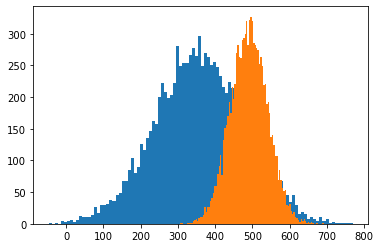

In [333]:
arrival_err   = 120
departure_err = 50
dt = 130


arival_time = 6 * 60
dep_time    = arival_time + dt


results = np.zeros(100)
for exp in range(len(results)):
    truck_arrivals = np.random.normal(loc=arival_time, scale=arrival_err, size=10000)
    ship_depatures = np.random.normal(loc=dep_time, scale=departure_err, size=10000)
    waiting_trucks = 0
    for i in range(len(truck_arrivals)):
        if truck_arrivals[i] > ship_depatures[i]:
            waiting_trucks +=1
    results[exp] = (waiting_trucks / 10000)


plt.hist(truck_arrivals, bins = 100)
plt.hist(ship_depatures, bins = 100)
plt.show()

In [334]:
print(np.mean(results))
print(np.std(results) / np.sqrt(100))


0.158808
0.0003540979525498559


In [336]:
arrival_err   = 120
departure_err = 50
dt_arr = np.arange(0, 500)

results = np.zeros(len(dt_arr))

for i, dt in enumerate(dt_arr):
    arival_time = 6 * 60
    dep_time    = arival_time + dt
    truck_arrivals = np.random.normal(loc=arival_time, scale=arrival_err, size=10000)
    ship_depatures = np.random.normal(loc=dep_time, scale=departure_err, size=10000)
    time = 0
    
    for j in range(len(truck_arrivals)):
        temp = ship_depatures[j] - truck_arrivals[j] 
        if temp > 0:
            time += temp
        else:
            time += 24 * 60 + temp
    results[i] =  time / len(truck_arrivals)

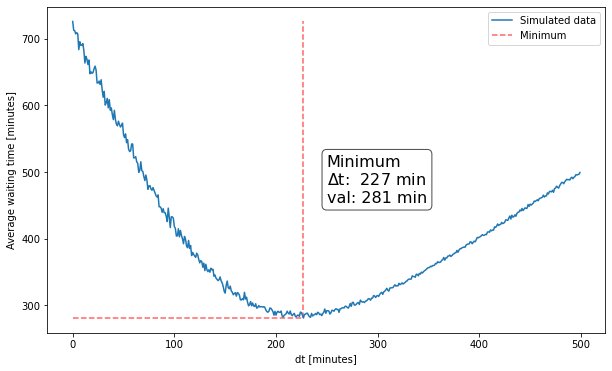

In [337]:
plt.figure(figsize = (10,6))
plt.plot(dt_arr, results, label = 'Simulated data')
plt.xlabel('dt [minutes]')
plt.ylabel('Average waiting time [minutes]')
min_val = dt_arr[np.argmin(results)]
plt.vlines(min_val, min(results), max(results), color = 'red', ls = 'dashed', alpha = 0.6, label = 'Minimum')
plt.hlines(min(results), 0, min_val, color = 'red', ls = 'dashed', alpha = 0.6)
d = ['Minimum',
    fr'$\Delta$t:  {min_val} min',
     f'val: {min(results):.0f} min']
text_box = '\n'.join(d)  # Join the lines with newline characters

plt.text(250, 450, text_box, fontsize=16, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.savefig('3_2_min.png')  # You can change the filename and format (e.g., 'plot.jpg', 'plot.svg', etc.)
plt.legend()

In [226]:
z_ship = dt / np.sqrt(arrival_err**2 + departure_err**2)
p_ship = stats.norm.sf(z_ship)
print(p_ship)

0.15865525393145707


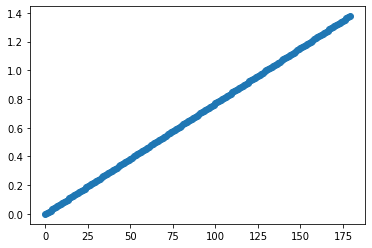

In [204]:
dt_arr = np.arange(0, 180)
z_arr  = dt_arr / np.sqrt(arrival_err**2 + departure_err**2)

plt.scatter(dt_arr, z_arr)

In [ ]:
print(np.random.normal(loc=0.0, scale=1.0, size=None))

In [26]:
print(day_window[-1]/130)

11.069230769230769


## 3.2

We can either use accept/reject or inverse transformation sampling. First lets examine the transformation method

What is the intergral and is it normalized?

The intergral is: $$F = -e^{-\frac{x'^2}{2\sigma^2}}$$

Evaluting this in the limits x' = [x, -inf]: $$U = e^{-\frac{x^2}{2\sigma^2}}$$

$$log(U) = -\frac{x^2}{2\sigma^2}$$
$$x = \sigma\sqrt{-2log(U)}$$ 


In [27]:
def sample_x(N, sigma):
    arr = np.random.uniform(size = N)
    return sigma * np.sqrt(-2 * np.log(1 - arr))

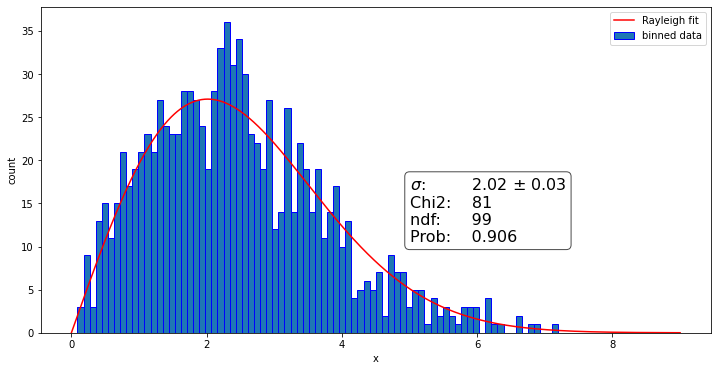

In [344]:
x_fit = np.linspace(0, 9, 1000)

Nbins = 100
sample = sample_x(1000, 2)

y, bin_edges = np.histogram(sample, bins=Nbins, range=(0, 9))
x = ((bin_edges[1:] + bin_edges[:-1])/2)

def rayleigh(x, sigma):
    k = (9) / Nbins          # binwidth
    N = 1000 * k             # Normalization
    return N * (x / sigma**2) * np.exp(-0.5 * x**2 / sigma**2)


def chi2(sigma):
    y_model = rayleigh(x, sigma)
    return np.sum((y - y_model)**2 / y_model)

fit = Minuit(chi2, 2) 
fit.errordef = 1
fit.migrad()         
fig, ax = plt.subplots(figsize = (12,6))

# extract fit values
sigma, sigma_err = fit.values[0], fit.errors[0]
Chi2_bin = fit.fval

d = [fr'$\sigma$:         {sigma:.2f} $\pm$ {sigma_err:.2f}',
     f'Chi2:    {Chi2_bin:.0f}',
     f'ndf:      {len(x) - 1}',
     f'Prob:    {stats.chi2.sf(Chi2_bin, len(x) - 1):.3f}']
text_box = '\n'.join(d)  # Join the lines with newline characters

ax.text(5, 10.2, text_box, fontsize=16, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


ax.bar(x, y, bin_width, edgecolor='blue', label = 'binned data')
ax.plot(x_fit, rayleigh(x_fit, sigma), color = 'red', label = 'Rayleigh fit')
plt.xlabel('x')
plt.ylabel('count')
ax.legend()
fig.savefig("3_2hist.png")


In [345]:
N_list = np.arange(50, 5000, 100)
err_list = np.zeros(len(N_list))

for i, N in enumerate(N_list):
    x_fit = np.linspace(0, 9, N)
    Nbins = 100
    sample = sample_x(N, 2)

    y, bin_edges = np.histogram(sample, bins=Nbins, range=(0, 9))
    x = ((bin_edges[1:] + bin_edges[:-1])/2)

    def rayleigh(x, sigma):
        k = (9) / Nbins          # binwidth
        j = N * k             # Normalization
        return j * (x / sigma**2) * np.exp(-0.5 * x**2 / sigma**2)
    
    def chi2(sigma):
        y_model = rayleigh(x, sigma)
        return np.sum((y - y_model)**2 / y_model)

    fit = Minuit(chi2, 2) #   
    fit.errordef = 1
    fit.migrad()         

    # extract fit values
    sigma, sigma_err = fit.values[0], fit.errors[0]
    err_list[i] = sigma_err

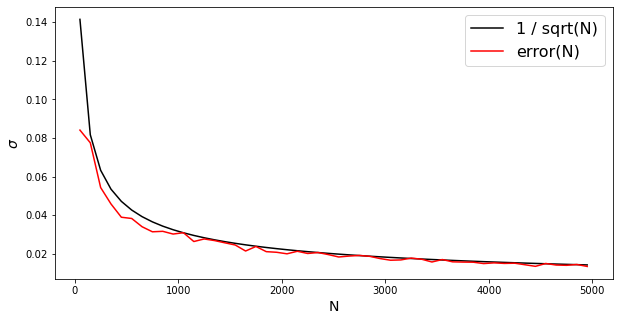

In [354]:
N_func = lambda N: 1 / np.sqrt(N)

plt.figure(figsize = (10,5))
plt.plot(N_list, N_func(N_list), label = '1 / sqrt(N)', color = 'black')
plt.plot(N_list, err_list, label = 'error(N)', color = 'red')
plt.xlabel('N', fontsize = 14)
plt.ylabel(r'$\sigma$', fontsize = 14)
plt.legend(fontsize  = 16)
plt.savefig('3_2_err.png')  # You can change the filename and format (e.g., 'plot.jpg', 'plot.svg', etc.)

plt.show()

This look good, but lets try to fit it to $$f(N) = N^{\alpha}$$ and plot the result on a log-log scale!

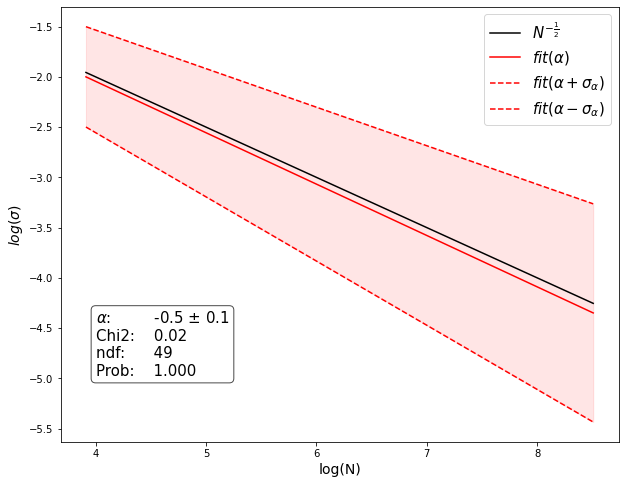

KstestResult(statistic=0.1, pvalue=0.9667464356809096)


In [384]:
fit_N  = lambda alpha:  N_list**alpha
chi2_N = lambda alpha: np.sum((err_list - fit_N(alpha))**2 / fit_N(alpha))
fit_N_obj = Minuit(chi2_N, -0.5) #   
fit_N_obj.errordef = 1
fit_N_obj.migrad()         

# extract fit values
alpha, alpha_err = fit_N_obj.values[0], fit_N_obj.errors[0]
Chi2_N = fit_N_obj.fval

plt.figure(figsize = (10,8))
plt.plot(np.log(N_list), np.log(N_func(N_list)), label = r'$N^{-\frac{1}{2}}$', color = 'black')
plt.plot(np.log(N_list), np.log(fit_N(alpha)), label = r'$fit(\alpha)$', color = 'red')

# plot the range of error for the fit
plt.plot(np.log(N_list), np.log(fit_N(alpha + alpha_err)), label = r'$fit(\alpha + \sigma_{\alpha})$', ls = 'dashed', color = 'red')
plt.plot(np.log(N_list), np.log(fit_N(alpha - alpha_err)), label = r'$fit(\alpha - \sigma_{\alpha})$', ls = 'dashed', color = 'red')
plt.fill_between(np.log(N_list), np.log(fit_N(alpha + alpha_err)), np.log(fit_N(alpha - alpha_err)), color='red', alpha=0.1)


d = [fr'$\alpha$:         {alpha:.1f} $\pm$ {alpha_err:.1f}',
     f'Chi2:    {Chi2_N:.2f}',
     f'ndf:      {len(N_list) - 1}',
     f'Prob:    {stats.chi2.sf(Chi2_N, len(N_list) - 1):.3f}']
text_box = '\n'.join(d)  # Join the lines with newline characters
plt.text(4, -5, text_box, fontsize=15, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.xlabel('log(N)', fontsize = 14)
plt.ylabel(r'$log(\sigma)$', fontsize = 14)
plt.legend(fontsize  = 15)
plt.savefig('3_2_err_log.png')  # You can change the filename and format (e.g., 'plot.jpg', 'plot.svg', etc.)

plt.show()
print(stats.kstest(err_list, N_func(N_list)))

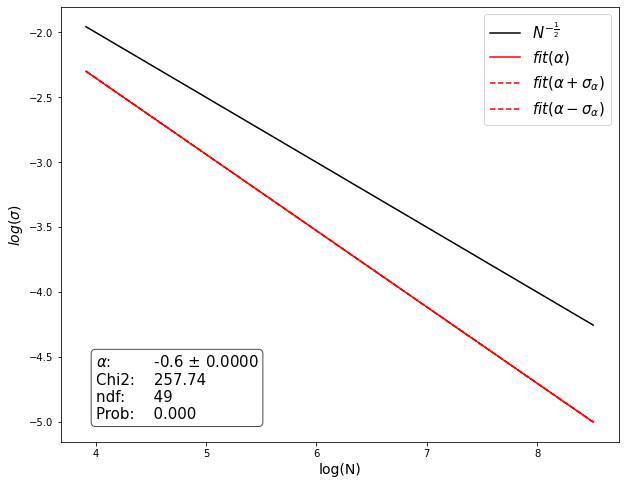

In [503]:
#fit_N  = lambda alpha: N_list**alpha
#chi2_N = lambda alpha: np.sum((err_list - fit_N(alpha))**2 / fit_N(alpha))
#fit_N_obj = Minuit(chi2_N, 0.5) #   
#fit_N_obj.errordef = 1
#fit_N_obj.migrad()         

fit_N  = lambda X, alpha: X**alpha
ullh_object_fit = UnbinnedLH(fit_N, N_list, bound=(min(N_list), max(N_list)), extended=True)
fit_N_obj = Minuit(ullh_object_fit, alpha=-0.5)
fit_N_obj.migrad()


# extract fit values
alpha, alpha_err = fit_N_obj.values[0], fit_N_obj.errors[0]
Chi2_N = fit_N_obj.fval

plt.figure(figsize = (10,8))
plt.plot(np.log(N_list), np.log(N_func(N_list)), label = r'$N^{-\frac{1}{2}}$', color = 'black')
plt.plot(np.log(N_list), np.log(fit_N(N_list, alpha)), label = r'$fit(\alpha)$', color = 'red')

# plot the range of error for the fit
plt.plot(np.log(N_list), np.log(fit_N(N_list, alpha + alpha_err)), label = r'$fit(\alpha + \sigma_{\alpha})$', ls = 'dashed', color = 'red')
plt.plot(np.log(N_list), np.log(fit_N(N_list, alpha - alpha_err)), label = r'$fit(\alpha - \sigma_{\alpha})$', ls = 'dashed', color = 'red')
plt.fill_between(np.log(N_list), np.log(fit_N(N_list,alpha + alpha_err)), np.log(fit_N(N_list,alpha - alpha_err)), color='red', alpha=0.1)


d = [fr'$\alpha$:         {alpha:.1f} $\pm$ {alpha_err:.4f}',
     f'Chi2:    {Chi2_N:.2f}',
     f'ndf:      {len(N_list) - 1}',
     f'Prob:    {stats.chi2.sf(Chi2_N, len(N_list) - 1):.3f}']
text_box = '\n'.join(d)  # Join the lines with newline characters
plt.text(4, -5, text_box, fontsize=15, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.xlabel('log(N)', fontsize = 14)
plt.ylabel(r'$log(\sigma)$', fontsize = 14)
plt.legend(fontsize  = 15)
plt.savefig('3_2_err_log.png')  # You can change the filename and format (e.g., 'plot.jpg', 'plot.svg', etc.)

plt.show()

In [518]:
fit_N  = lambda X, alpha: X**alpha
ullh_object_fit = UnbinnedLH(fit_N, N_list, bound=(min(N_list), max(N_list)), extended=True)
fit_N_obj = Minuit(ullh_object_fit, alpha=-0.5)
fit_N_obj.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 257.7                      │              Nfcn = 105              │
│ EDM = 8.82e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha │-587.7413e-3│ 0.0004e-3 │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────┐
│       │    alpha │
├───────┼──────────┤
│ alpha │ 1.57e-13 │
└───────┴──────────┘

In [443]:
print(err_list)

[0.0840525  0.07748438 0.05430331 0.04579319 0.03892094 0.03827347
 0.03400167 0.03137547 0.03162418 0.03020718 0.03089943 0.026334
 0.0276629  0.02683038 0.02566305 0.02453862 0.02141639 0.02376753
 0.02108826 0.02076502 0.0199714  0.02128625 0.02013978 0.02063298
 0.01956224 0.01832286 0.01880616 0.01912113 0.01865731 0.0175014
 0.01665081 0.01680164 0.01775141 0.01717979 0.01573797 0.01700195
 0.0158139  0.01568505 0.01561943 0.01491349 0.01527934 0.01499385
 0.01510192 0.01429947 0.01348292 0.01496102 0.01415228 0.01400857
 0.01444514 0.0134265 ]


# 4

In [361]:
# display the data
dataframe = pd.read_csv('data_AnorocDisease.csv', header=0)
PatientID_C, Temp_C, BloodP_C, Age_C, Status_C = dataframe.values[:800].T
PatientID_U, Temp_U, BloodP_U, Age_U, Status_U = dataframe.values[800:-1].T
dataframe

,PatientID,Temp,BloodP,Age,Status (0: Healthy; 1: Ill; -1: Unknown)
0,1.0,36.3,125.7,56.8,0.0
1,2.0,37.6,121.4,67.7,1.0
2,3.0,38.7,117.6,67.3,1.0
3,4.0,35.8,116.3,60.0,0.0
4,5.0,37.6,142.9,81.9,0.0
...,...,...,...,...,...
995,996.0,37.1,127.6,74.2,-1.0
996,997.0,36.9,123.7,47.1,-1.0
997,998.0,37.3,113.4,39.2,-1.0
998,999.0,37.0,129.3,68.3,-1.0


## 4.1

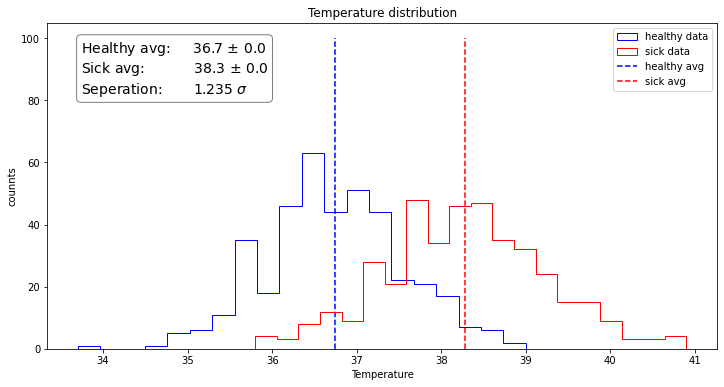

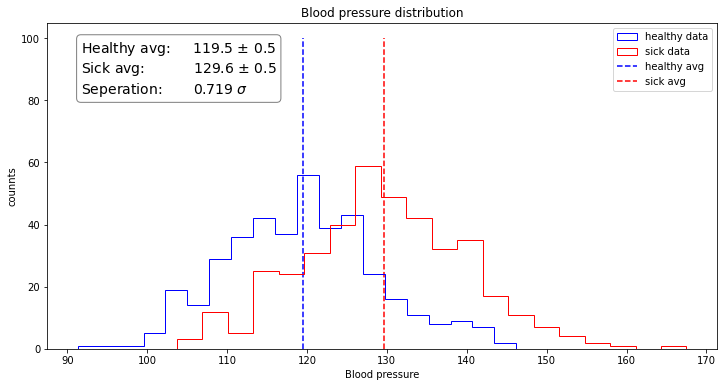

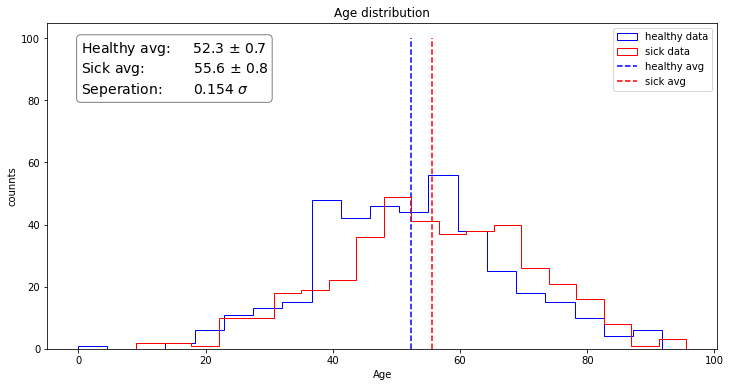

In [362]:
healthy_mask = Status_C == 0
sick_mask    = Status_C == 1
Nbins = 20

metrics = {'Temperature':Temp_C, 'Blood pressure': BloodP_C, 'Age':Age_C}
for metric in metrics:
    H, S  = metrics[metric][healthy_mask], metrics[metric][sick_mask]
    H_avg, H_err = np.mean(H), np.std(H) / np.sqrt(len(H))
    S_avg, S_err = np.mean(S), np.std(S) / np.sqrt(len(S))
    rel_diff     = (S_avg-H_avg)/ H_avg
        
    plt.figure(figsize = (12,6))
    plt.hist(metrics[metric][healthy_mask], bins= Nbins, label = 'healthy data',histtype='step', color = 'blue')
    plt.hist(metrics[metric][sick_mask], bins= Nbins, label = 'sick data', histtype='step',color = 'red')    
    plt.vlines(H_avg, 0, 100, label = 'healthy avg', color = 'blue', ls = 'dashed')
    plt.vlines(S_avg, 0, 100, label = 'sick avg', color = 'red', ls = 'dashed')
    
    d = [fr'Healthy avg:     {H_avg:.1f} $\pm$ {H_err:.1f}',
         fr'Sick avg:           {S_avg:.1f} $\pm$ {S_err:.1f}',
     fr'Seperation:       {calc_separation(H, S):.3f} $\sigma$']
    text_box = '\n'.join(d)  # Join the lines with newline characters

    # Adding the text box to the plot
    plt.text(0.05, 0.95, text_box, transform=plt.gca().transAxes, fontsize=14, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.xlabel(metric)
    plt.ylabel('counnts')
    plt.title(metric + ' distribution')
    plt.legend()
    plt.show()
    

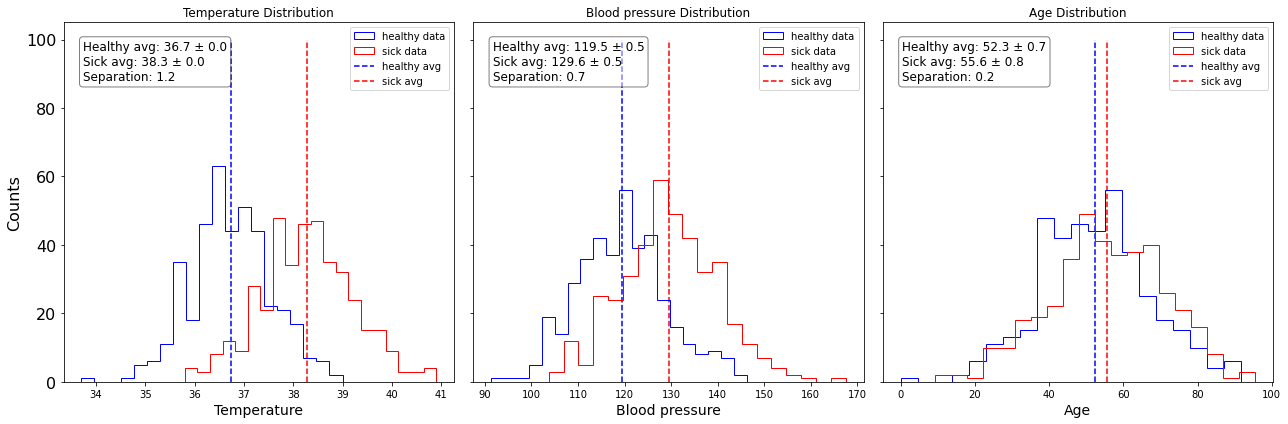

In [364]:

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Iterate over metrics and plot in subplots
for i, (metric, values) in enumerate(metrics.items()):
    ax = axes[i]
    H, S = values[healthy_mask], values[sick_mask]
    H_avg, H_err = np.mean(H), np.std(H) / np.sqrt(len(H))
    S_avg, S_err = np.mean(S), np.std(S) / np.sqrt(len(S))

    ax.hist(values[healthy_mask], bins=Nbins, label='healthy data', histtype='step', color='blue')
    ax.hist(values[sick_mask], bins=Nbins, label='sick data', histtype='step', color='red')
    ax.vlines(H_avg, 0, 100, label='healthy avg', color='blue', ls='dashed')
    ax.vlines(S_avg, 0, 100, label='sick avg', color='red', ls='dashed')

    d = [f'Healthy avg: {H_avg:.1f} ± {H_err:.1f}',
         f'Sick avg: {S_avg:.1f} ± {S_err:.1f}',
         f'Separation: {calc_separation(H, S):.1f} ']
    text_box = '\n'.join(d)

    ax.text(0.05, 0.95, text_box, transform=ax.transAxes, fontsize=12, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    ax.set_xlabel(metric, fontsize = 14)
    if i == 0:  # Set y-axis label only for the first subplot
        ax.set_ylabel('Counts', fontsize = 16)  
    else:
        ax.set_yticklabels([])  # Remove y-axis tick labels for other subplots
    ax.set_title(metric + ' Distribution')
    ax.legend()
axes[0].tick_params(axis='y', labelsize=16)  # Adjust the size as needed
# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('4_1.png')  # You can change the filename and format (e.g., 'plot.jpg', 'plot.svg', etc.)

plt.show()


Lets compare the healthy/sick the age distributions to see if they are the same. We can test the null hypothesis that these are the same distribution by using the ks (Kolmogorov smirnov) test. This works since our distributions have the same ordering (aka age) and are somewhat continues! It is implemented easily using the scipy.stats library.

In [34]:
ks_age = stats.kstest(Age_C[healthy_mask], Age_C[sick_mask])
print(f' With a p value = {ks_age.pvalue:.3f}, we can reject the hypothesis that these distributions are the same')

 With a p value = 0.002, we can reject the hypothesis that these distributions are the same


To seperate the two groups..  CHECK THE DEGREES OF FREEDOM DFO

In [137]:
def ficher_plot(healthy_list, sick_list, N_bins):
    covmat_healthy = np.cov(healthy_list)
    covmat_sick = np.cov(sick_list)

    covmat_comb = covmat_healthy + covmat_sick
    covmat_comb_inv = inv(covmat_comb)
    
    mu_healthy = np.mean(healthy_list, axis = 1)
    mu_sick    = np.mean(sick_list, axis = 1)
    wf = covmat_comb_inv @ (mu_healthy - mu_sick)
    fisher_healthy = np.sum(np.array(healthy_list).T * wf, axis = 1)
    fisher_sick    = np.sum(np.array(sick_list).T * wf, axis = 1)
    
    fig_fisher, ax_fisher = plt.subplots(figsize=(12, 6))
    H = ax_fisher.hist(fisher_healthy, N_bins, (-45, -34), histtype='step', color='Blue', label='Healthy individuals')
    S = ax_fisher.hist(fisher_sick, N_bins, (-45, -34), histtype='step', color='Red', label='Sick individuals')
    ax_fisher.set(xlabel='Fisher-discriminant', ylabel='Counts / 2')
    ax_fisher.legend(fontsize=20)

    ax_fisher.text(-36, 7, fr'$\Delta_{{fisher}} = {calc_separation(fisher_healthy, fisher_sick):.3f}$', fontsize=16)

    fig_fisher.tight_layout()
    return H, S, wf


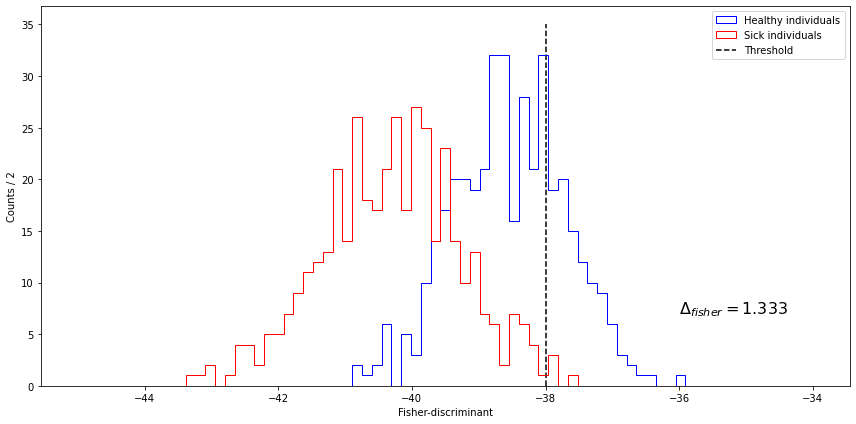

In [149]:
H, S, weights = ficher_plot([Temp_C[healthy_mask], BloodP_C[healthy_mask], Age_C[healthy_mask]],
           [Temp_C[sick_mask], BloodP_C[sick_mask], Age_C[sick_mask]], 75)
plt.vlines(-38, 0, 35, label='Threshold', color='black', ls='dashed')
plt.legend()
plt.savefig('4_1_ficher.png')  # You can change the filename and format (e.g., 'plot.jpg', 'plot.svg', etc.)


Since we would much rather have False positives, than miss True postive, we set the threshold rather aggresively. For now, lets say a F = -38

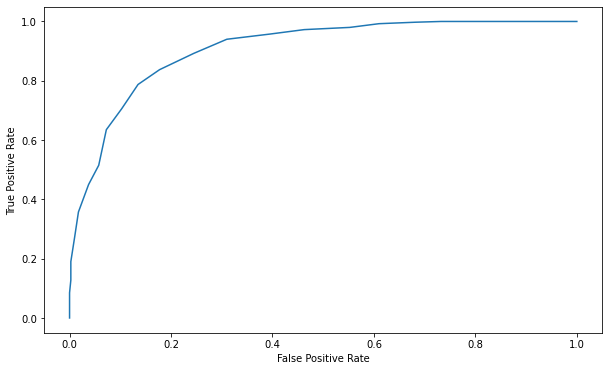

In [37]:
N_bins = 100
FPR, TPR = calc_ROC(H, S)

plt.figure(figsize = (10, 6))
plt.plot(FPR, TPR, '-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Possibly add a fit of two gaussians to the ficher plot

In [38]:
h_count, h_sig_edges, _ = H
s_counts, s_sig_edges, _ = S

In [39]:
def model(temp, blood_p, age):
    F = np.sum(weights * np.array([temp, blood_p, age]).T)
    if F < -38:
        return 1
    return 0

In [150]:
predictions = []
for i in range(len(PatientID_U)):
    predictions.append(model(Temp_U[i], BloodP_U[i], Age_U[i]))
    
n_sick = sum(predictions)

print(f' Out of {len(predictions)} individuals, we predict that {n_sick} of them are sick')

 Out of 199 individuals, we predict that 158 of them are sick


In [41]:
def hist_gauss(x, min_x, max_x, p0 = [0, 0], bins = 30):
    x_fit = np.linspace(min_x, max_x, 1000)
    counts, edges = np.histogram(x, bins = bins, range = (min_x, max_x))
    mask = counts > 0

    y = counts[mask]
    x = ((edges[1:] + edges[:-1])/2)[mask]
    bin_width = np.diff(edges)[mask]
    total_area = np.sum(y * bin_width)
    err = np.sqrt(y)

    def chi2_gauss(mu, sigma):
        y_model = total_area * gauss_pdf(x , mu, sigma)
        return np.sum((y - y_model)**2 / y_model)

    fit = Minuit(chi2_gauss, *p0) 
    fit.errordef = 1
    fit.migrad()         

    # extract fit values
    mu, sigma = fit.values[:]
    mu_err, sigma_err = fit.errors[:]
    Chi2_gauss = fit.fval

    #plt.figure(figsize = (12,6))
    d = [fr'$\mu$:         {mu:.2f} $\pm$ {mu_err:.2f}',
         fr'$\sigma$:         {sigma:.2f} $\pm$ {sigma_err:.2f}',
         f'Chi2:    {Chi2_gauss:.2f}',
         f'ndf:      {len(y) - 2}',
         f'Prob:    {stats.chi2.sf(Chi2_gauss, len(y) - 2):.2f}']
    text_box = '\n'.join(d)  # Join the lines with newline characters

    return x, y, bin_width, [x_fit, total_area * gauss_pdf(x_fit, mu, sigma)], text_box, [mu, sigma]

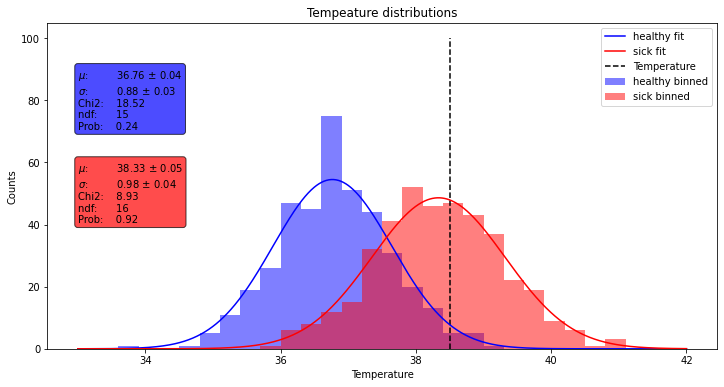

In [154]:
T_predict = 38.5
x_H, y_H, b_H, f_H, text_box_H, val_H = hist_gauss(Temp_C[healthy_mask], 33, 42, [37, 1])
x_S, y_S, b_S, f_S, text_box_S, val_S = hist_gauss(Temp_C[sick_mask], 33, 42, [37, 1])


plt.figure(figsize = (12, 6))
plt.title('Tempeature distributions')
plt.xlabel('Temperature')
plt.ylabel('Counts')

plt.bar(x_H, y_H, b_H, alpha = 0.5, label = 'healthy binned', color = 'blue')
plt.bar(x_S, y_S, b_S, alpha = 0.5, label = 'sick binned',color = 'red')

plt.plot(*f_H, color = 'blue', label = 'healthy fit')
plt.plot(*f_S, color = 'red', label = 'sick fit')

plt.vlines(T_predict, ymin = 0, ymax = 100, color = 'black', ls = 'dashed', label =  'Temperature')
plt.text(33, 70, text_box_H, fontsize=10, va='bottom', bbox=dict(boxstyle='round', facecolor='blue', alpha=0.7))
plt.text(33, 40, text_box_S, fontsize=10, va='bottom', bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))


plt.legend()
plt.savefig('4_1_temp.png')  # You can change the filename and format (e.g., 'plot.jpg', 'plot.svg', etc.)

plt.show()

p(sick | T  = 38.5) = p(T = 38.5| sick) * p(sick) / p(T = 38.5)
p(sick | T  = 38.5) = p(T = 38.5| sick)  * prior / p(T = 38.5)
p(sick | T  = 38.5) = p(T = 38.5| sick)  * prior / (p(T|sick) * p(sick) + p(T|healthy) * p(healthy))
p(sick | T  = 38.5) = p(T = 38.5| sick)  * prior / (p(T|sick) * p(sick) + p(T|healthy) * (1 - p(sick))


In [304]:
p_H = stats.norm.pdf(T_predict, *val_H)
p_S = stats.norm.pdf(T_predict, *val_S)
prior = 0.01

print(f'p(T = 38.5 | healthy) = {p_H:.2f}')
print(f'p(T = 38.5 | sick)    = {p_S:.2f}')

p(T = 38.5 | healthy) = 0.06
p(T = 38.5 | sick)    = 0.40


In [305]:
p = p_S * prior / (p_S * prior + p_H * (1 - prior))
print(f'Postirior probability = {p:.2f}')

Postirior probability = 0.06


# 4.2
## a)

In [3]:
dataframe = pd.read_csv('data_CountryScores.csv', header=0, index_col=None)
Country, GDP, PopSize, HappinessI, EconomicFreedomI, PressFreedomI, EducationI = dataframe.values.T
dataframe

NameError: name 'pd' is not defined

In [160]:
mean_GDP      = np.mean(GDP)
std_GDP       = np.std(GDP)
quantile1_GDP = np.quantile(GDP, 0.1587)
quantile2_GDP = np.quantile(GDP, 0.8413)

print( np.quantile(GDP, 0.5))
print(mean_GDP)
print(std_GDP)
print(median_GDP)
print(quantile1_GDP)
print(quantile2_GDP)

6677.0
17362.045112781954
23750.457989367944
1188.0
1187.2259999999999
40850.23440000002


## b)

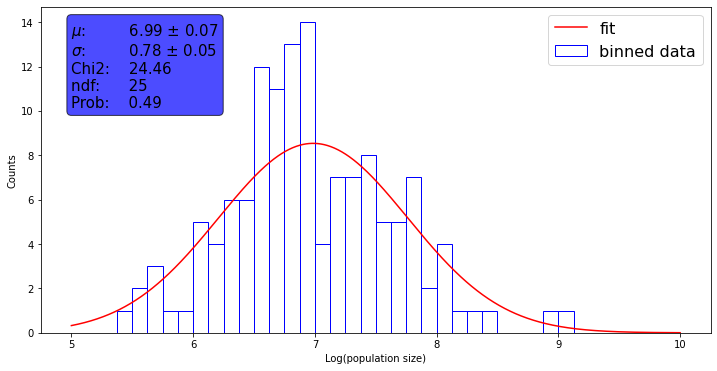

In [168]:
log10_PopSize = [np.log10(element) for element in PopSize]

x, y, b, f, text_box, val = hist_gauss(log10_PopSize, 5, 10, [7, 1], 40)
plt.figure(figsize = (12,6))
plt.bar(x, y, b, label = 'binned data',  edgecolor='blue', fill=False)
plt.plot(*f, color = 'red', label = 'fit')
plt.text(5, 10, text_box, fontsize=15, va='bottom', bbox=dict(boxstyle='round', facecolor='blue', alpha=0.7))

plt.legend(fontsize = 16)
plt.xlabel('Log(population size)')
plt.ylabel('Counts')

plt.savefig('4_2.png')  # You can change the filename and format (e.g., 'plot.jpg', 'plot.svg', etc.)

plt.show()

## c)

In [48]:
correlation_pear = stats.pearsonr(HappinessI, EducationI)
correlation_spearman = stats.spearmanr(HappinessI, EducationI)

print(*correlation_pear)
print(*correlation_spearman)

0.7647440306793953 8.91736545435073e-27
0.8043593869327467 2.065314967435993e-31


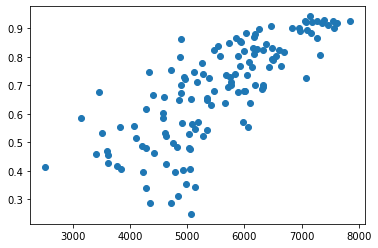

In [169]:
plt.scatter(HappinessI, EducationI)

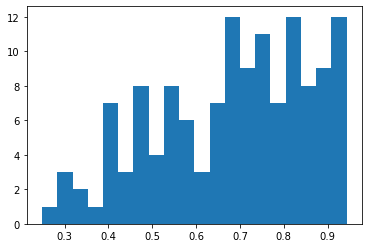

In [396]:
plt.hist(EducationI, bins = 20)
plt.show()

In [458]:


ullh_object_fit = UnbinnedLH(fit_func, GDP, bound=(min(GDP), max(GDP)))
GDP_fit = Minuit(ullh_object_fit, a = 0.1, b= 1, c = 0)
GDP_fit.migrad()

<ipython-input-458-147581412827>:2: RuntimeWarning: overflow encountered in power
  return a * b**x + c


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 306.2                      │             Nfcn = 1272              │
│ EDM = 1.15e+06 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.100   │   0.012   │            │            │         │         │       │
│ 1 │ b    │  1.0000   │  0.0009   │            │            │         │         │       │
│ 2 │ c    │     0     │  1.2e-6   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         a         b         c │
├───┼───────────────────────────────┤
│ a │   0.00015        -0   9.0e-12 │
│ b │        -0  8.66e-07 -11.9e-12 │
│ c │   9.0e-12 -11.9e-12  1.44e-12 │
└───┴───────────────────────────────┘

## d)

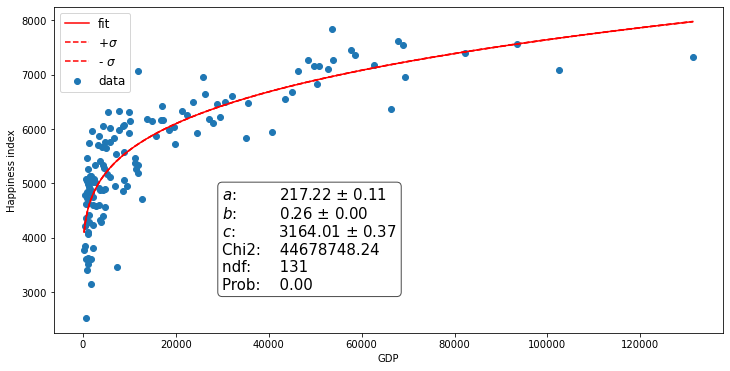

In [495]:
def fit_func(x, a, b, c):
    return a * x**b + c


def chi_fit_func(a, b, c):
    model = fit_func(GDP, a, b, c)
    return np.sum((HappinessI - model)**2)

#ullh_object_fit = UnbinnedLH(fit_func, GDP, bound=(min(GDP), max(GDP)))
#GDP_fit = Minuit(ullh_object_fit, a =1, b= 1, c= 0)
#GDP_fit.migrad()


GDP_fit = Minuit(chi_fit_func, 1, 0.1, 10)
GDP_fit.errordef = 1
GDP_fit.migrad()  

a, b, c = GDP_fit.values[:]
a_err, b_err, c_err = GDP_fit.errors[:]
Chi2_fit = GDP_fit.fval
p = stats.chi2.sf(Chi2_fit, len(GDP) - 2)

def prop_err(x):
    return np.sqrt((x**b * a_err)**2 + (a * b * x**(b-1) * b_err)**2 + (c_err)**2)



d = [fr'$a$:         {a:.2f} $\pm$ {a_err:.2f}',
     fr'$b$:         {b:.2f} $\pm$ {b_err:.2f}',
     fr'$c$:         {c:.2f} $\pm$ {c_err:.2f}',
     f'Chi2:    {Chi2_fit:.2f}',
     f'ndf:      {len(GDP) - 2}',
     f'Prob:    {p:.2f}']
text_box = '\n'.join(d)  # Join the lines with newline characters

x_fit = np.linspace(min(GDP), max(GDP), 10000)
fit   = fit_func(x_fit, a, b, c) 
fit_err = prop_err(x_fit)

plt.figure(figsize = (12,6))
plt.scatter(GDP, HappinessI, label = 'data')
plt.plot(x_fit, fit, label = 'fit', color = 'red')
plt.plot(x_fit, fit + fit_err, label = r'+$\sigma$', color = 'red', ls='dashed')
plt.plot(x_fit, fit - fit_err, label = r'- $\sigma$', color = 'red', ls='dashed')
plt.fill_between(x_fit, fit + fit_err, fit - fit_err, alpha = 0.1)

plt.text(30000, 3000, text_box, fontsize=15, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.xlabel('GDP')
plt.ylabel('Happiness index')
plt.legend(fontsize = 12)
plt.savefig('4_2fit.png')  # You can change the filename and format (e.g., 'plot.jpg', 'plot.svg', etc.)

plt.show()

579.5950637509391


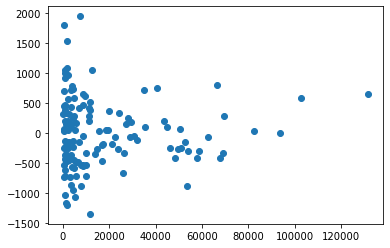

In [486]:
plt.scatter(GDP, fit_func(GDP, a, b, c) - HappinessI)

err = np.sqrt(np.sum((fit_func(GDP, a, b, c) - HappinessI)**2) / len(GDP))
print(err)

<ipython-input-41-8412e628117c>:14: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((y - y_model)**2 / y_model)


Text(5, 10, '$\\mu$:         7.00 $\\pm$ nan\n$\\sigma$:         1.00 $\\pm$ nan\nChi2:    inf\nndf:      12\nProb:    0.00')

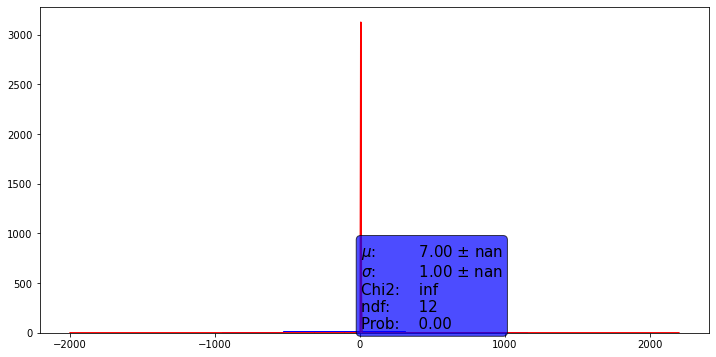

In [494]:
x, y, b, f, text_box, val = hist_gauss(fit_func(GDP, a, b, c) - HappinessI.astype('float'), -2000, 2200, [7, 1], 20)
plt.figure(figsize = (12,6))
plt.bar(x, y, b, label = 'binned data',  edgecolor='blue', fill=False)
plt.plot(*f, color = 'red', label = 'fit')
plt.text(5, 10, text_box, fontsize=15, va='bottom', bbox=dict(boxstyle='round', facecolor='blue', alpha=0.7))


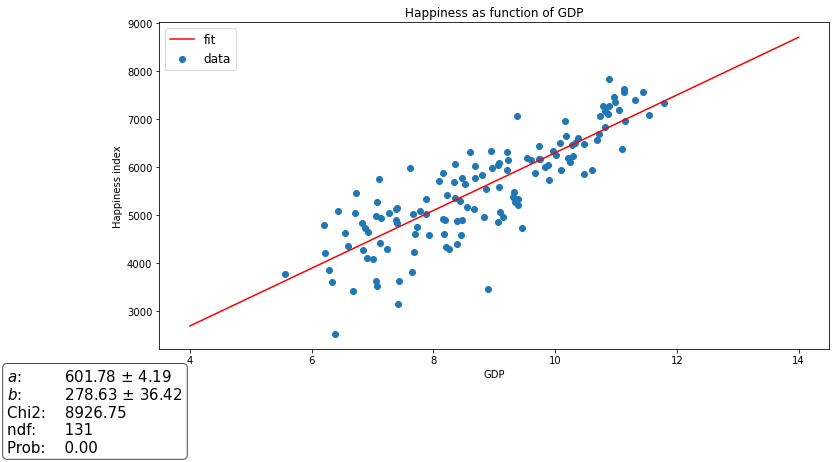

In [50]:

def fit_func(x, a, b):
    return a * x + b

GDP_log = np.log(GDP.astype('float64'))

def chi_fit_func(a, b):
    model = fit_func(GDP_log, a, b)
    return np.sum((HappinessI - model)**2 / model)


GDP_fit = Minuit(chi_fit_func, 1, 1)
GDP_fit.errordef = 1
GDP_fit.migrad()  

a, b= GDP_fit.values[:]
a_err, b_err = GDP_fit.errors[:]
Chi2_fit = GDP_fit.fval
p = stats.chi2.sf(Chi2_fit, len(GDP) - 2)

d = [fr'$a$:         {a:.2f} $\pm$ {a_err:.2f}',
     fr'$b$:         {b:.2f} $\pm$ {b_err:.2f}',
     f'Chi2:    {Chi2_fit:.2f}',
     f'ndf:      {len(GDP) - 2}',
     f'Prob:    {p:.2f}']
text_box = '\n'.join(d)  # Join the lines with newline characters

x_fit = np.linspace(4, 14, 10000)
    
plt.figure(figsize = (12,6))
plt.title('Happiness as function of GDP')
plt.scatter(np.log(GDP.astype('float64')), HappinessI, label = 'data')
plt.plot(x_fit, fit_func(x_fit, a, b), label = 'fit', color = 'red')

plt.text(1, 1, text_box, fontsize=15, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.xlabel('GDP')
plt.ylabel('Happiness index')
plt.legend(fontsize = 12)
plt.show()


# 5

In [51]:
dataframe = pd.read_csv('data_GlacierSizes.csv', header=0, index_col=None)
Area, sigArea, Volume, sigVolume = dataframe.values.T
dataframe

,Area,sigArea,Volume,sigVolume
0,2.44922,0.02758,0.10127,0.01091
1,2.48328,0.03630,0.10776,0.00834
2,1.54516,0.02648,0.04989,0.00349
3,2.45672,0.03140,0.06795,0.00104
4,1.45687,0.02270,0.03490,0.00312
...,...,...,...,...
429,2.08141,0.02792,0.10545,0.00791
430,1.76906,0.02897,0.05093,0.00681
431,1.59750,0.02184,0.06665,0.00568
432,1.95797,0.03534,0.06338,0.00384


## 5.1

0.3411661560167413
Average error on the area: ± 0.05
Average error on the volume: ± 0.02


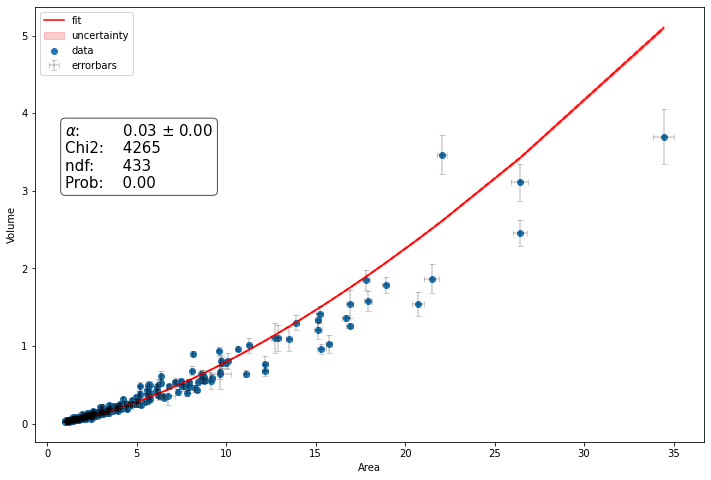

0.02521747637145566 ± 8.05226762203279e-05
p_val = 0.0 
chi = 4265.106850306416


In [605]:
avg_sigArea   = np.mean(sigArea)
avg_sigVolume = np.mean(sigVolume)
print((avg_sigArea- avg_sigVolume)/ np.sqrt((np.std(sigArea)**2 + (np.std(sigVolume)**2))))
#print(np.std(sigArea) / len(sigArea))
#print(np.std(sigVolume) / len(sigVolume))


print(f'Average error on the area: \u00B1 {np.round(avg_sigArea, 2)}')
print(f'Average error on the volume: \u00B1 {np.round(avg_sigVolume, 2)}')

fit_area = np.linspace(min(Area), max(Area), 1000)
vol_area = lambda alpha: alpha * Area**(3/2)

chi2_5   = lambda alpha: np.sum(((Volume - vol_area(alpha)) / sigVolume)**2)
VA_fit = Minuit(chi2_5, 1) #   
VA_fit.errordef = 1
VA_fit.migrad()         

# extract fit values
alpha, alpha_err = VA_fit.values[0], VA_fit.errors[0]
Chi2_VA = VA_fit.fval
p = stats.chi2.sf(Chi2_VA, len(Area) - 1)

plt.figure(figsize = (12,8))
plt.plot(sorted(Area), sorted(vol_area(alpha)), color = 'red', label = 'fit')
plt.plot(sorted(Area), sorted(vol_area(alpha + alpha_err)), color = 'red', ls = 'dashed', alpha = 0.5)
plt.plot(sorted(Area), sorted(vol_area(alpha - alpha_err)), color = 'red', ls = 'dashed', alpha = 0.5)
plt.fill_between(sorted(Area), sorted(vol_area(alpha + alpha_err)), sorted(vol_area(alpha - alpha_err)), color='red', alpha=0.2, label = 'uncertainty')

plt.scatter(Area, Volume, label = 'data')
plt.errorbar(Area, Volume, xerr = sigArea, yerr = sigVolume,  marker='', linestyle='', capsize=3, ecolor='black', label = 'errorbars', alpha = 0.2)
plt.xlabel('Area')
plt.ylabel('Volume')
d = [fr'$\alpha$:         {alpha:.2f} $\pm$ {alpha_err:.2f}',
     f'Chi2:    {Chi2_VA:.0f}',
     f'ndf:      {len(Area) - 1}',
     f'Prob:    {p:.2f}']
text_box = '\n'.join(d)  # Join the lines with newline characters
plt.text(1, 3, text_box, fontsize=15, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.legend()
plt.savefig('5_1fit.png')  # You can change the filename and format (e.g., 'plot.jpg', 'plot.svg', etc.)

plt.show()
print(f'{alpha} \u00B1 {alpha_err}')
print(f'p_val = {p} ')
print(f'chi = {Chi2_VA}')


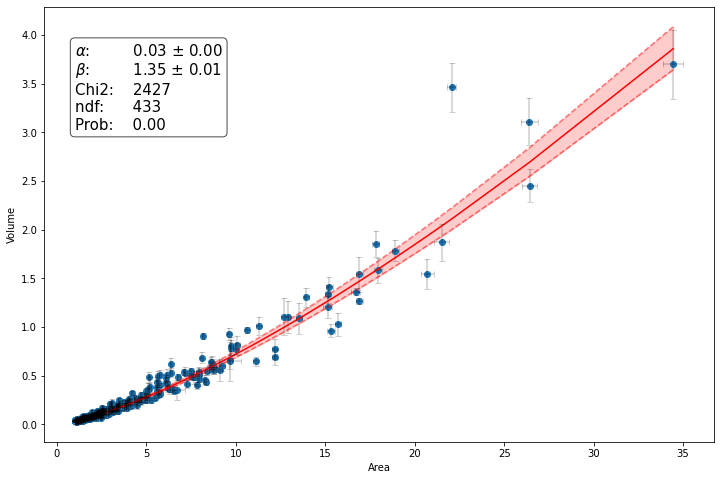

0.03203860395674962 ± 0.0006687889822087277
1.3539957330839285 ± 0.010209624233874264
p_val = 7.049782994857242e-274 
chi = 2426.9857263511444
ddof = 433


In [606]:
vol_area = lambda alpha, beta, ceta: alpha * (Area)**(beta) + ceta

prop_err = lambda alpha, beta: np.sqrt((sigArea * alpha * beta * Area**(beta-1))**2 + sigVolume**2)

chi2_5   = lambda alpha, beta, ceta: np.sum(((Volume - vol_area(alpha, beta, ceta)) / prop_err(alpha, beta))**2)
VA_fit = Minuit(chi2_5, 1, 1.5, 0) #   
VA_fit.errordef = 1
VA_fit.migrad()  


# extract fit values
alpha, beta, ceta = VA_fit.values[:]
alpha_err, beta_err, ceta_err = VA_fit.errors[:]
Chi2_VA = VA_fit.fval
p = stats.chi2.sf(Chi2_VA, len(Area) - 1)

v_plus = sorted(vol_area(alpha + alpha_err, beta + beta_err, ceta + ceta_err))
v_minus = sorted(vol_area(alpha - alpha_err, beta -beta_err, ceta - ceta_err))
                

plt.figure(figsize = (12,8))
plt.plot(sorted(Area), sorted(vol_area(alpha, beta, ceta)), color = 'red')
plt.plot(sorted(Area), v_plus, color = 'red', ls = 'dashed', alpha = 0.5)
plt.plot(sorted(Area), v_minus, color = 'red', ls = 'dashed', alpha = 0.5)
plt.fill_between(sorted(Area), v_plus,v_minus, color='red', alpha=0.2)

plt.scatter(Area, Volume)
plt.errorbar(Area, Volume, xerr = sigArea, yerr = sigVolume,  marker='', linestyle='', capsize=3, ecolor='black', label = 'errorbars', alpha = 0.2)
plt.xlabel('Area')
plt.ylabel('Volume')
d = [fr'$\alpha$:         {alpha:.2f} $\pm$ {alpha_err:.2f}',
     fr'$\beta$:         {beta:.2f} $\pm$ {beta_err:.2f}',
     f'Chi2:    {Chi2_VA:.0f}',
     f'ndf:      {len(Area) - 1}',
     f'Prob:    {p:.2f}']
text_box = '\n'.join(d)  # Join the lines with newline characters
plt.text(1, 3, text_box, fontsize=15, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.savefig('5_2fit.png')  # You can change the filename and format (e.g., 'plot.jpg', 'plot.svg', etc.)
plt.show()
print(f'{alpha} \u00B1 {alpha_err}')
print(f'{beta} \u00B1 {beta_err}')


print(f'p_val = {p} ')
print(f'chi = {Chi2_VA}')
print(f'ddof = {len(Area) - 1}')

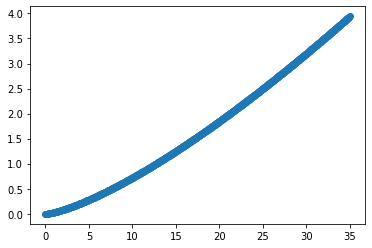

In [580]:
X = np.linspace(0, 35, 1000)
plt.scatter(X, alpha * (X)**(beta) + ceta)

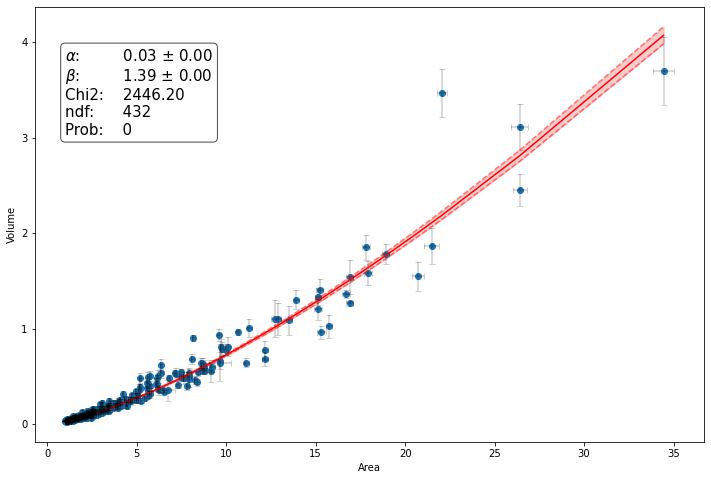

0.029332767889314264 ± 0.0001633176398603273
1.3937396766048034 ± 0.004620266744418417
p_val = 2.585495198653187e-277 
chi = 2446.203368422458
ddof = 433


In [603]:
vol_area = lambda alpha, beta: alpha * (Area)**beta


prop_err = lambda alpha, beta: np.sqrt((sigArea * alpha * beta * Area**(beta-1))**2 + sigVolume**2)

chi2_5   = lambda alpha, beta: np.sum(((Volume - vol_area(alpha, beta)) / prop_err(alpha, beta))**2)
VA_fit = Minuit(chi2_5, 0.3, 0) #   
VA_fit.errordef = 1
VA_fit.migrad()         

# extract fit values
alpha, beta = VA_fit.values[:]
alpha_err, beta_err = VA_fit.errors[:]
Chi2_VA = VA_fit.fval
p = stats.chi2.sf(Chi2_VA, len(Area) - 1)

v_plus = sorted(vol_area(alpha + alpha_err, beta + beta_err))
v_minus = sorted(vol_area(alpha - alpha_err, beta -beta_err))
                

plt.figure(figsize = (12,8))
plt.plot(sorted(Area), sorted(vol_area(alpha, beta)), color = 'red')
plt.plot(sorted(Area), v_plus, color = 'red', ls = 'dashed', alpha = 0.5)
plt.plot(sorted(Area), v_minus, color = 'red', ls = 'dashed', alpha = 0.5)
plt.fill_between(sorted(Area), v_plus,v_minus, color='red', alpha=0.2)

plt.scatter(Area, Volume)
plt.errorbar(Area, Volume, xerr = sigArea, yerr = sigVolume,  marker='', linestyle='', capsize=3, ecolor='black', label = 'errorbars', alpha = 0.2)
plt.xlabel('Area')
plt.ylabel('Volume')
d = [fr'$\alpha$:         {alpha:.2f} $\pm$ {alpha_err:.2f}',
     fr'$\beta$:         {beta:.2f} $\pm$ {beta_err:.2f}',
     f'Chi2:    {Chi2_VA:.2f}',
     f'ndf:      {len(Area) - 2}',
     f'Prob:    {p:.0f}']
text_box = '\n'.join(d)  # Join the lines with newline characters
plt.text(1, 3, text_box, fontsize=15, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.show()
print(f'{alpha} \u00B1 {alpha_err}')
print(f'{beta} \u00B1 {beta_err}')


print(f'p_val = {p} ')
print(f'chi = {Chi2_VA}')
print(f'ddof = {len(Area) - 1}')

In [581]:
predict_Area  = 0.5
target_Volume = alpha * predict_Area**(beta)
target_err    = np.sqrt((alpha_err * predict_Area**beta)**2 + (np.log(beta) * beta_err * alpha * predict_Area**beta)**2)
print(f'Predicted vol: {target_Volume:.3f} \u00B1 {target_err:.3f}')

Predicted vol: 0.013 ± 0.000


(1.0, 40.0)

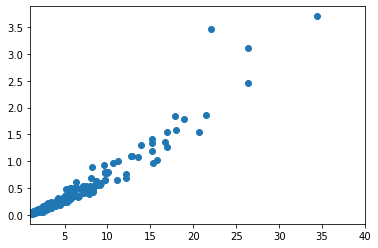

In [588]:
plt.scatter(Area, Volume)
plt.xlim(1,40)